## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
from multiprocessing import Pool
import statsmodels.api as sm

## Summary

Here we try to define the Ito SDE

$dX = \mu(X,t)dt + \sigma(X,t)dB$

where $\mu(X,t)$ is the drift coefficient and $\sigma(X,t)$ is diffusion coefficient, $B$ is Brownian motion

In this code, we test 2 simple cases:
- Variance exploding, or simple Wiener process $dX = \sqrt{\frac{d[\sigma^{2}(t)]}{dt}}dB$
- Variance preserving $dX = -\frac{1}{2}\beta(t)Xdt + \sqrt{\beta(t)}dB$

## Variance exploding

Note that the process $dX = \sqrt{\frac{d[\sigma^{2}(t)]}{dt}}dB$ has the following discretized Markov chain version:

$x_{t}=x_{t-1}+\sqrt{\sigma_{t}^{2}-\sigma_{t-1}^{2}}z_{t-1}$

where $z\sim\mathcal{N}(0,I)$

For fast convergence, we use

$x_{t}=x_{t-1}+\sqrt{\sigma_{t}^{2}}z_{t-1}$

In [2]:
# draw x from gaussian mixtures
class_mean = [0, -10, 10]
class_var = [1, 2, 3]
class_probs = [0.4, 0.35, 0.25]

if np.sum(class_probs) != 1.0:
    raise("Total class probs should be 1.0")

In [3]:
N = 10000
xs = np.random.randn(N)
np.random.shuffle(xs)

begin = 0
for idx, cl in enumerate(class_probs):
    end = begin + int(N*cl)
    xs[begin:end] = class_mean[idx] + np.sqrt(class_var[idx])*xs[begin:end]
    begin = end 

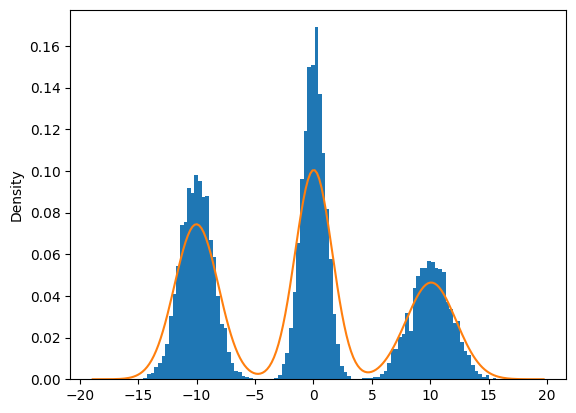

In [4]:
fig = plt.figure()
plt.hist(xs, bins=100, density=True)
sns.kdeplot(xs)
plt.show()

In [5]:
# define number of steps and noise schedule
T = 1000
sigma = np.linspace(0.1, 0.2, T)

# perform noising
xs_all = [xs]
x_t = xs
for idx in tqdm.tqdm(range(1,T)):
    n = np.random.randn(N)
    x_t_next = x_t + np.sqrt(sigma[idx])*n
    x_t = x_t_next
    xs_all.append(x_t)
xs_noised = x_t
xs_all = np.array(xs_all)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 5520.78it/s]


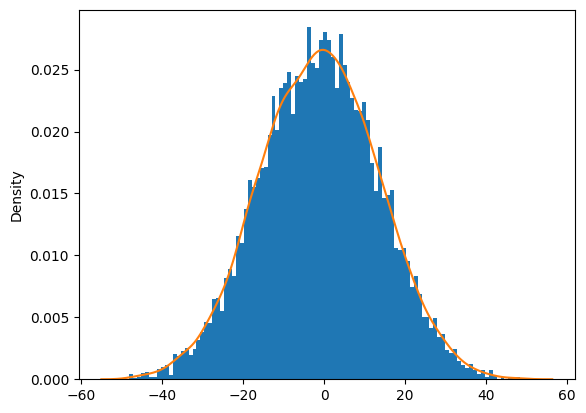

In [6]:
fig = plt.figure()
plt.hist(xs_all[-1], bins=100, density=True)
sns.kdeplot(xs_all[-1])
plt.show()

In [7]:
def kde_at_idx(idx):
    # scipy way - seem to be much slower
    # kernel = scipy.stats.gaussian_kde(xs_all[idx])
    # grid = np.linspace(np.min(xs_all[idx]), np.max(xs_all[idx]), N)
    # Z = kernel(grid)
    
    # statsmodels way
    kde = sm.nonparametric.KDEUnivariate(xs_all[idx]).fit()
    x, y = (kde.support, kde.density)
    return y

In [8]:
# parallel kde calculation for each step
with Pool(20) as pool:
    results = list(tqdm.tqdm(pool.imap(kde_at_idx, np.arange(T)), total=T))
    
Zs = np.array(results)
Zs_norm = Zs/np.sum(Zs, axis=1).reshape((-1,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4810.42it/s]


In [9]:
Zs_norm.shape

(1000, 16384)

In [10]:
# sample from density values to plot faster
sample_idx = np.linspace(0, Zs.shape[1]-1, 10000, dtype=int)
Zs_sample = Zs[:, sample_idx]
Zs_sample_norm = Zs_sample/np.sum(Zs_sample, axis=1).reshape((-1,1))

In [11]:
Zs_sample_norm.shape

(1000, 10000)

In [12]:
# random_path = np.random.randint(0, N, 300)
# plt.plot(xs_all[:,random_path], color="black", alpha=0.3)
# plt.ylim(-16, 16)
# plt.show()

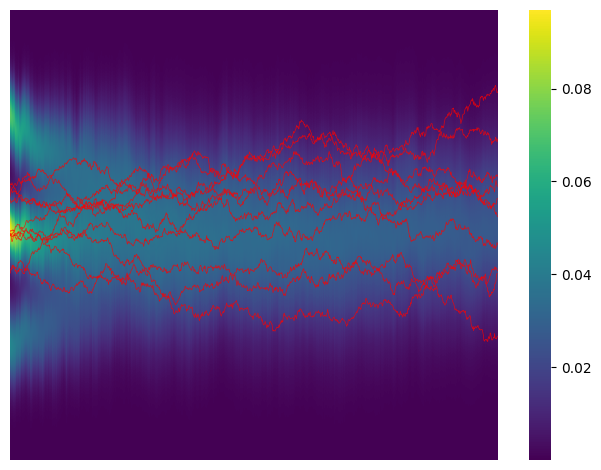

In [13]:
fig = plt.figure()
ax = sns.heatmap(Zs_sample.T, cmap="viridis")
ax2 = plt.twinx(ax)
rand_idx = np.random.randint(0, N, 10)
random_path = xs_all.T[rand_idx]
for r in random_path:
    sns.lineplot(r, ax=ax2, color="red", alpha=0.8, linewidth = 0.5)
ax.axis("off")
ax2.axis("off")
ax2.set_ylim(np.min(xs_all),np.max(xs_all))
plt.tight_layout()
plt.show()

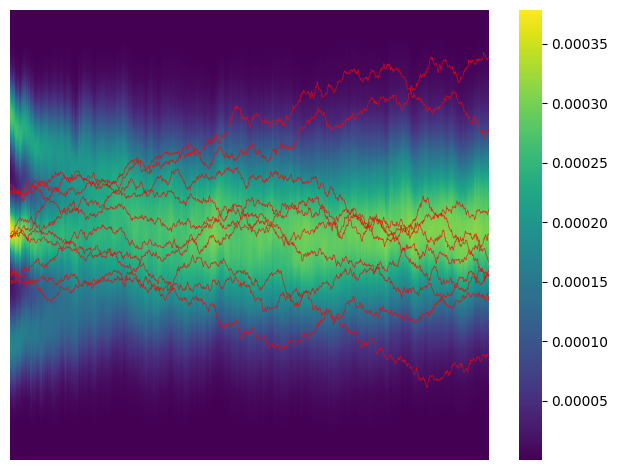

In [14]:
fig = plt.figure()
ax = sns.heatmap(Zs_sample_norm.T, cmap="viridis")
ax2 = plt.twinx(ax)
rand_idx = np.random.randint(0, N, 10)
random_path = xs_all.T[rand_idx]
for r in random_path:
    sns.lineplot(r, ax=ax2, color="red", alpha=0.8, linewidth = 0.5)
ax.axis("off")
ax2.axis("off")
ax2.set_ylim(np.min(xs_all),np.max(xs_all))
plt.tight_layout()
plt.show()

## Variance preserving

The process $dX = -\frac{1}{2}\beta(t)Xdt + \sqrt{\beta(t)}dB$ has the following approximated Markov chain

$X_{t} = \sqrt{1-\beta_{t}}X_{t-1} + \sqrt{\beta_{t}}z$

where $z\sim\mathcal{N}(0,I)$

In [3]:
# draw x from gaussian mixtures
class_mean = [0, -10, 10]
class_var = [1, 2, 3]
class_probs = [0.4, 0.35, 0.25]

if np.sum(class_probs) != 1.0:
    raise("Total class probs should be 1.0")

In [77]:
N = 1000000
xs = np.random.randn(N)
np.random.shuffle(xs)

begin = 0
for idx, cl in enumerate(class_probs):
    end = begin + int(N*cl)
    xs[begin:end] = class_mean[idx] + np.sqrt(class_var[idx])*xs[begin:end]
    begin = end 

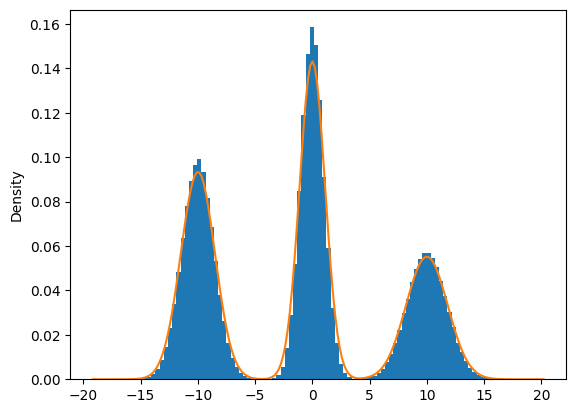

In [78]:
fig = plt.figure()
plt.hist(xs, bins=100, density=True)
sns.kdeplot(xs)
plt.show()

In [16]:
# define number of steps and noise schedule
T = 1000
sigma = np.linspace(0.001, 0.02, T)

# perform noising
xs_all = [xs]
x_t = xs
for idx in tqdm.tqdm(range(1,T)):
    n = np.random.randn(N)
    x_t_next = np.sqrt(1-sigma[idx])*x_t + np.sqrt(sigma[idx])*n
    # x_t_next = 0.8*x_t + np.sqrt(sigma[idx])*n
    x_t = x_t_next
    xs_all.append(x_t)
xs_noised = x_t
xs_all = np.array(xs_all)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 6195.79it/s]


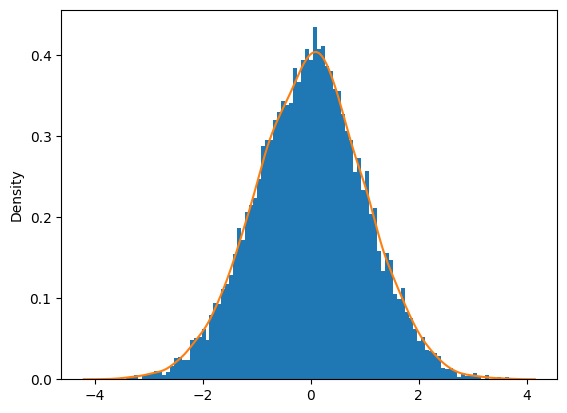

In [17]:
fig = plt.figure()
plt.hist(xs_all[-1], bins=100, density=True)
sns.kdeplot(xs_all[-1])
plt.show()

# NOTE HOW THE VARIANCE IS PRESERVED

In [18]:
def kde_at_idx(idx):
    # scipy way - seem to be much slower
    # kernel = scipy.stats.gaussian_kde(xs_all[idx])
    # grid = np.linspace(np.min(xs_all[idx]), np.max(xs_all[idx]), N)
    # Z = kernel(grid)
    
    # statsmodels way
    kde = sm.nonparametric.KDEUnivariate(xs_all[idx]).fit()
    x, y = (kde.support, kde.density)
    return y

In [19]:
# parallel kde calculation for each step
with Pool(20) as pool:
    results = list(tqdm.tqdm(pool.imap(kde_at_idx, np.arange(T)), total=T))
    
Zs = np.array(results)
Zs_norm = Zs/np.sum(Zs, axis=1).reshape((-1,1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4430.91it/s]


In [20]:
Zs_norm.shape

(1000, 16384)

In [21]:
# sample from density values to plot faster
sample_idx = np.linspace(0, Zs.shape[1]-1, 10000, dtype=int)
Zs_sample = Zs[:, sample_idx]
# Zs_sample = Zs_sample[np.arange(100), :]
Zs_sample_norm = Zs_sample/np.sum(Zs_sample, axis=1).reshape((-1,1))

In [22]:
Zs_sample_norm.shape

(1000, 10000)

In [23]:
# random_path = np.random.randint(0, N, 300)
# plt.plot(xs_all[:,random_path], color="black", alpha=0.3)
# plt.ylim(-16, 16)
# plt.show()

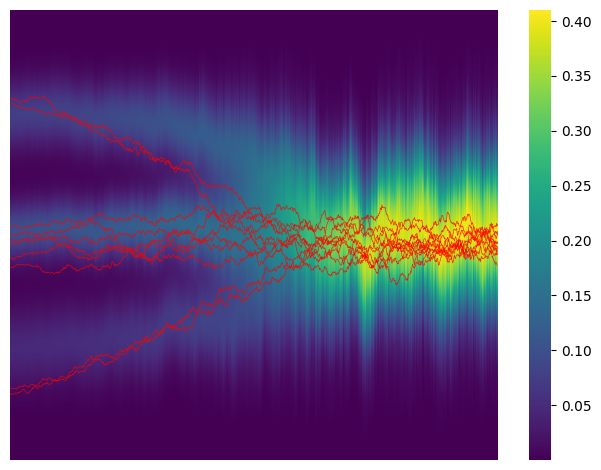

In [24]:
fig = plt.figure()
ax = sns.heatmap(Zs.T, cmap="viridis")
ax2 = plt.twinx(ax)
rand_idx = np.random.randint(0, N, 10)
random_path = xs_all.T[rand_idx]
for r in random_path:
    sns.lineplot(r, ax=ax2, color="red", alpha=0.8, linewidth = 0.5)
ax.axis("off")
ax2.axis("off")
ax2.set_ylim(np.min(xs_all),np.max(xs_all))
plt.tight_layout()
plt.show()

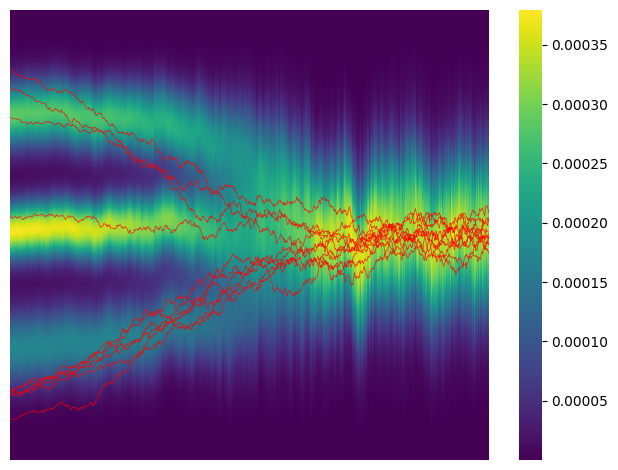

In [25]:
fig = plt.figure()
ax = sns.heatmap(Zs_sample_norm.T, cmap="viridis")
ax2 = plt.twinx(ax)
rand_idx = np.random.randint(0, N, 10)
random_path = xs_all.T[rand_idx]
for r in random_path:
    sns.lineplot(r, ax=ax2, color="red", alpha=0.8, linewidth = 0.5)
ax.axis("off")
ax2.axis("off")
ax2.set_ylim(np.min(xs_all),np.max(xs_all))
plt.tight_layout()
plt.show()